In [1]:
import os
import csv
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.ndimage import label

In [3]:
# CONFIGURACIÓN

NNUNET_DIR = "/media/guest/PORT-DISK/Practicas/MicroBleeds/nnUNet_raw_data/TaskVALDO"
LABELS_DIR = os.path.join(NNUNET_DIR, "labelsTr")

OUTPUT_CSV = "/media/guest/PORT-DISK/Practicas/MicroBleeds/VALDO_analisis_CMBs.csv"

In [4]:
# FUNCIÓN PARA ANALIZAR LESIONES EN UNA MÁSCARA

def analyze_mask(label_path):
    nii = nib.load(label_path)
    mask = nii.get_fdata().astype(np.uint8)
    spacing = nii.header.get_zooms()  # mm per voxel

    # Connected components
    labeled, num = label(mask)

    lesion_volumes_vox = []
    lesion_volumes_mm3 = []

    for lesion_idx in range(1, num + 1):
        voxels = np.sum(labeled == lesion_idx)
        lesion_volumes_vox.append(voxels)

        # volumen en mm^3
        voxel_vol = spacing[0] * spacing[1] * spacing[2]
        lesion_volumes_mm3.append(voxels * voxel_vol)

    return num, lesion_volumes_vox, lesion_volumes_mm3

In [ ]:
# RECORRER TODOS LOS PACIENTES Y GUARDAR CSV

rows = []

label_files = sorted([f for f in os.listdir(LABELS_DIR) if f.endswith(".nii.gz")])

for f in label_files:
    subject = f.replace(".nii.gz", "")
    path = os.path.join(LABELS_DIR, f)

    num_lesions, vol_vox, vol_mm3 = analyze_mask(path)

    for vvox, vmm in zip(vol_vox, vol_mm3):
        rows.append([subject, num_lesions, vvox, vmm])

# Guardar CSV
with open(OUTPUT_CSV, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["subject", "num_lesions", "volume_voxels", "volume_mm3"])
    writer.writerows(rows)

print("CSV guardado en:", OUTPUT_CSV)

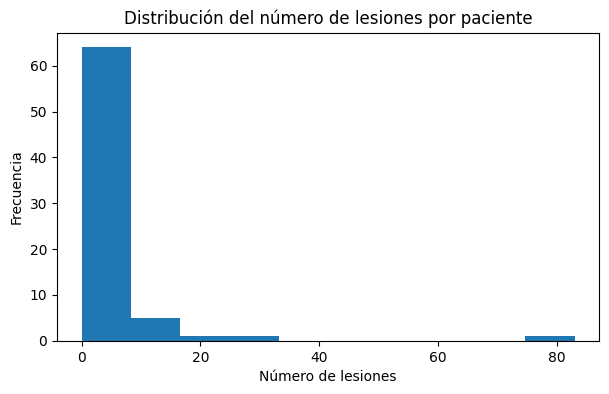

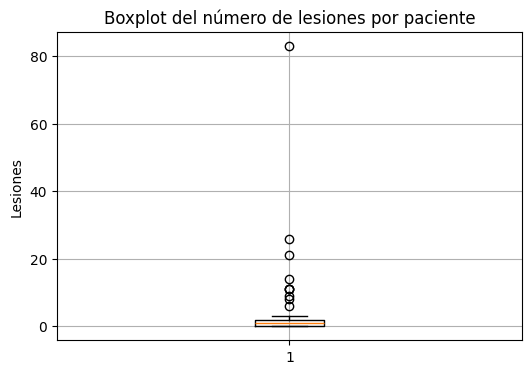

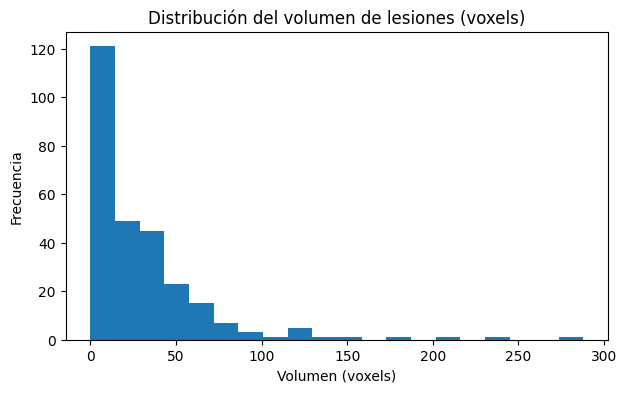

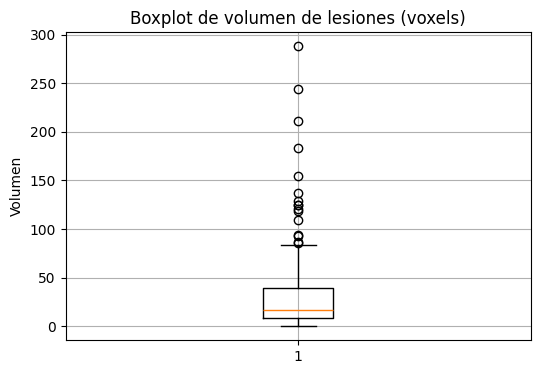

In [5]:
# CARGAR DATOS PARA GRÁFICAS

import pandas as pd
df = pd.read_csv(OUTPUT_CSV)

# GRÁFICAS — DISTRIBUCIONES

# ---------- Histograma número de lesiones ----------
plt.figure(figsize=(7,4))
df.groupby("subject").first()["num_lesions"].hist(bins=10)
plt.title("Distribución del número de lesiones por paciente")
plt.xlabel("Número de lesiones")
plt.ylabel("Frecuencia")
plt.grid()
plt.show()

# ---------- Boxplot número de lesiones ----------
plt.figure(figsize=(6,4))
plt.boxplot(df.groupby("subject").first()["num_lesions"])
plt.title("Boxplot del número de lesiones por paciente")
plt.ylabel("Lesiones")
plt.grid()
plt.show()

# ---------- Histograma volumen de lesiones ----------
plt.figure(figsize=(7,4))
df["volume_voxels"].hist(bins=20)
plt.title("Distribución del volumen de lesiones (voxels)")
plt.xlabel("Volumen (voxels)")
plt.ylabel("Frecuencia")
plt.grid()
plt.show()

# ---------- Boxplot volumen ----------
plt.figure(figsize=(6,4))
plt.boxplot(df["volume_voxels"])
plt.title("Boxplot de volumen de lesiones (voxels)")
plt.ylabel("Volumen")
plt.grid()
plt.show()